In [1]:
import acquire
import prepare
import explore
import model

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(13, 10))
plt.rc('font', size=16)
plt.style.use('seaborn-darkgrid')

import warnings
warnings.filterwarnings('ignore')

# Github Repository Language Prediction: a Machine Learning Approach Using Natural Language Processing

## Project Goal

The goal of this project was to predict the programming language used in Github repositories based on the contents of the README file. The ability to classify repositories based on the README is useful for search engine optimization and potentially for data storage strategies. Features from the README texts were built leveraging natural language processing techniques such as bag of words and tf-idf scores. These features were inputted to numerous machine learning classification models to predict the programming language based on the README text.

## Data Acquisition

Data was acquired from 150 data science repositories from three different programming languages: Python, C++, and Java. The list of repositories acquired was based on performing a search for "machine learning" and specifying the programming language. Acquisition is accomplished using the acquire.py module and results in a dataset with 50 repositories for each language. The acquired data is also saved to a data.json cache to allow for faster subsequent loads.

In [2]:
# Acquire the data
df = acquire.get_repo_data()

Reading data from cache


Data consists of the repo name, language, and raw readme_contents.

In [3]:
# Take a quick look at df
df.head(2)

,repo,language,readme_contents
0,janishar/mit-deep-learning-book-pdf,Java,[![Download](https://img.shields.io/badge/down...
1,Angel-ML/angel,Java,![](assets/angel_logo.png)\n\n[![license](http...


## Data Preparation

The data was prepared by performing the following:
- Cleaning: converting text to lowercase, normalizing the text to remove inconsistencies in unicode character encoding, and encoding strings to ASCII. Also, any text not a through z, a number, a single quote, or whitespace was removed.
- Stemming: using the Porter method the stems of each word were extracted
- Lemmatizing: using the WordNetLemmatizer in nltk the root word was extracted
- Stopword removal: removing words with little or no significance to focus the exploration and modeling on words with lower frequency. Based on exploration extra words were added to the stopword removal process as these words did not add significant value to differentiating the repository's language.
- New features were made with the word counts and overall readme length, for the original, stemmed, and lemmatized versions.

In [4]:
# Extra words to include as a stopwords
extra_words = ['see', 'source', 'example', 'code', 'use', '1', "'", ';', '&#9']
# Call the prepare function from the script
prepared_data = prepare.prepare_df(df, column =  'readme_contents', extra_words = extra_words)

In [5]:
# Look at the prepare df
prepared_data.head(2)

,repo,language,readme_contents,clean,stemmed,lemmatized,original_length,stem_length,lem_length,original_word_count,stemmed_word_count,lemmatized_word_count
0,janishar/mit-deep-learning-book-pdf,Java,[![Download](https://img.shields.io/badge/down...,downloadhttpsimgshieldsiobadgedownloadbookmark...,downloadhttpsimgshieldsiobadgedownloadbookmark...,downloadhttpsimgshieldsiobadgedownloadbookmark...,2995,1971,2112,369,212,214
1,Angel-ML/angel,Java,![](assets/angel_logo.png)\n\n[![license](http...,assetsangellogopng licensehttpimgshieldsiobadg...,assetsangellogopng licensehttpimgshieldsiobadg...,assetsangellogopng licensehttpimgshieldsiobadg...,7394,5235,5508,511,349,350


The data was split into train, validate, and test sets for further exploration and modeling.

In [6]:
# Call split function
train, validate, test = prepare.train_validate_test_split(prepared_data, target = 'language')

## Exploration

We used our train split to explore the data. During exploration, we analyzed the data to answer the following questions:
- What are the most common words in the READMEs?
- Are WordClouds useful for visualizing relative frequency of words in each language?
- Does the length of the README vary by programming language?
- Do different programming languages use a different number of unique words?

### Question: What are the most common words in the READMEs?
We can create a new dataframe to represent the word counts of our READMEs by using segmenting our data by category and then taking the frequency of the individual words. For the sake of our exploration this was done using our lemmatized words. The frequencies are then combined into a single dataframe, word_counts, where we can analyze the outcomes.

In [7]:
# Calling the word_counts() function from the explore module with our train df
word_counts = explore.word_counts(train)

In [8]:
# An example of seeing what words are the most frequent overall, changing the column for by='{column}' we could
# specify which language we want to check the top frequency of words for. 
word_counts.sort_values(by='all', ascending=False).head()

,all,java,python,c++
install,1123,21,1007,95
codea,894,0,894,0
detail,712,7,678,27
pip,705,11,661,33
open,704,17,664,23


We can also visualize the overall most common words as a percentage of which language they are found with. The common_words() function in the Explore module will create a stacked bar plot to do this.

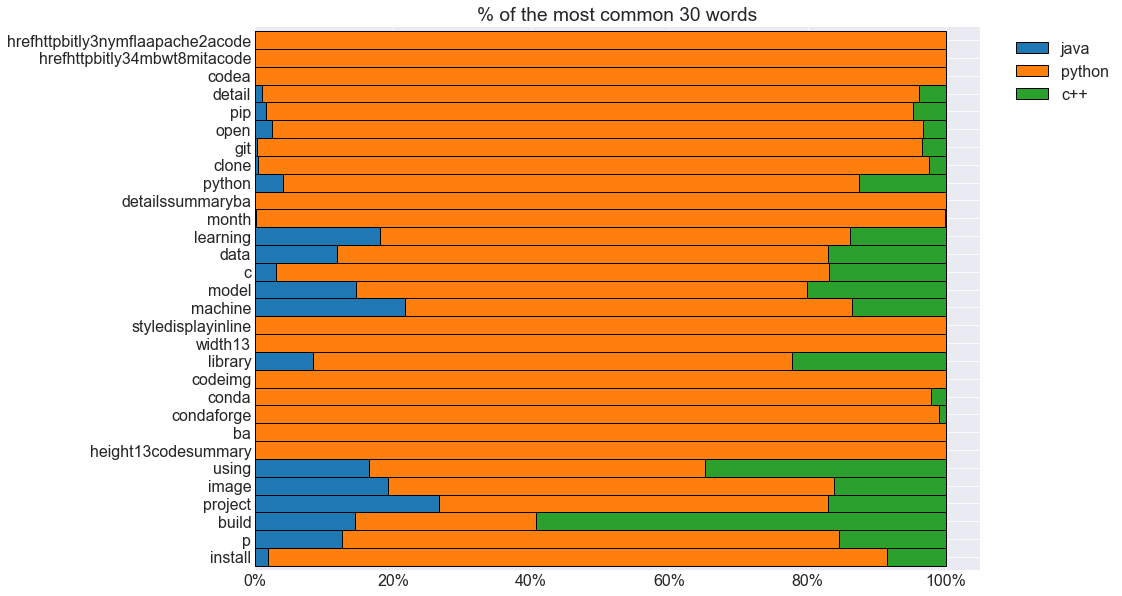

In [9]:
# Most common words sorted by each language
explore.common_words(word_counts)

**Takeaways**
- Python is the most commonly language followed by C++
- open, git, clone, conda, appear mostly in Python
- Words like : model, learning, machine, build are frequent words. They appear in all languages

### Question: What do WordClouds of each language look like?

A good way to visualize the words for our languages is to make WordClouds of the train dataframe. To do this the function word_cloud() from the explore module takes our train dataframe and a specified language (string) and outputs the visual.

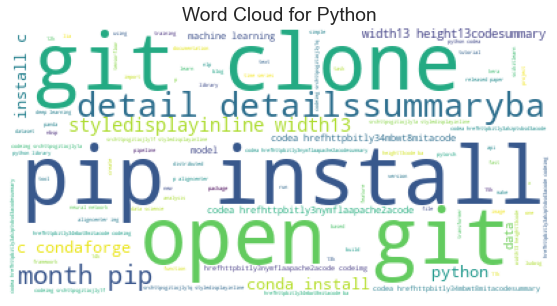

In [10]:
# WordCloud for Python
explore.word_cloud(train, 'Python')

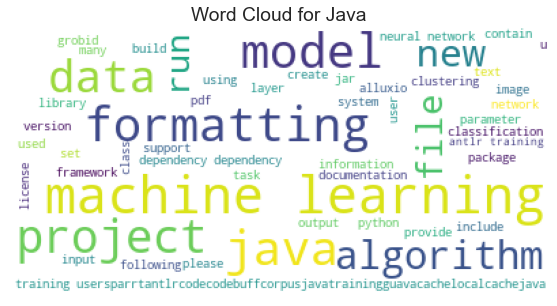

In [11]:
# WordCloud for Java
explore.word_cloud(train, 'Java')

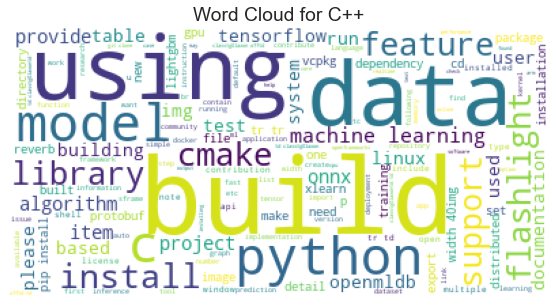

In [12]:
# WordCloud for C++
explore.word_cloud(train, 'C++')

**Takeaways**
- We can visually confirm that there are differences in languaged used for each coding language
- Python READMEs seem to be heavily associated with git or install commands
- Java READMEs seem to be heavily associated with words surrounding our searched topic (Machine Learning)
- C++ READMEs seem to be heavily associated with a some install words, specific library words, and oddly enough with the word 'Python'

### Question: Does the length of the README vary by programming language?

We can answer this by specifying language with groupby and then comparing the mean length of the documents.

In [13]:
# Find the readme length by programming language
train.groupby('language').lem_length.mean().sort_values(ascending=False)

language
Python    23603.142857
C++        4869.500000
Java       4403.142857
Name: lem_length, dtype: float64

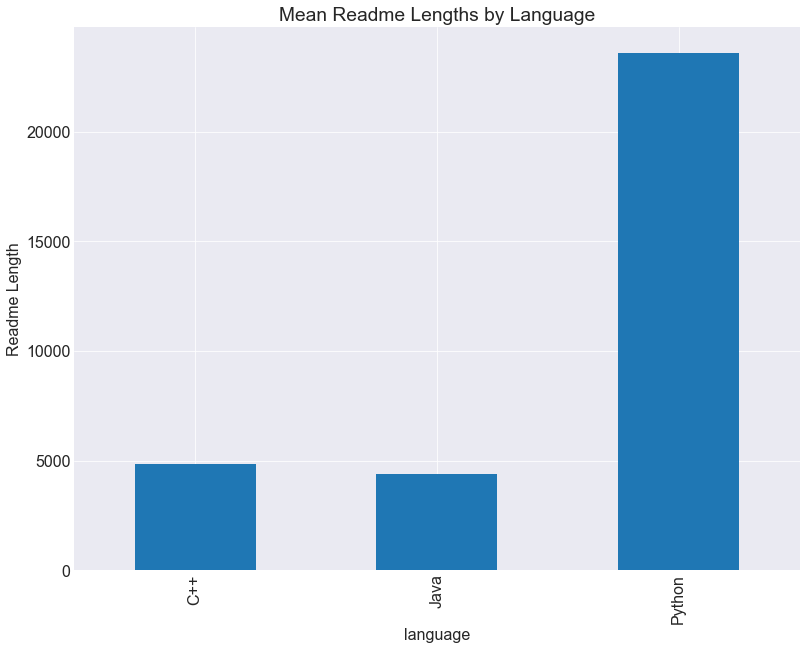

In [14]:
# A visualization of the above outcome
explore.bar_plot(train, 'language', 'lem_length')

In [15]:
# Perform 1 sample t-test comparing mean length of original README file per language to the overall average length (all languages)
# Set significance level to 0.05
explore.stat_test(train, 'original_length')

Java -10.17324 True
C++ -8.42402 True
Python 1.12877 False


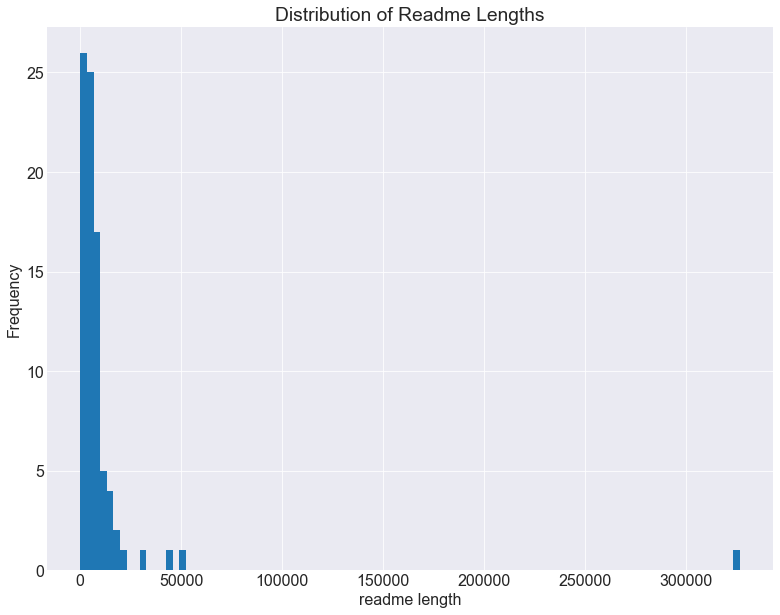

In [16]:
# Visualize distribution of README lengths
explore.hist_plot(train, 'lem_length')

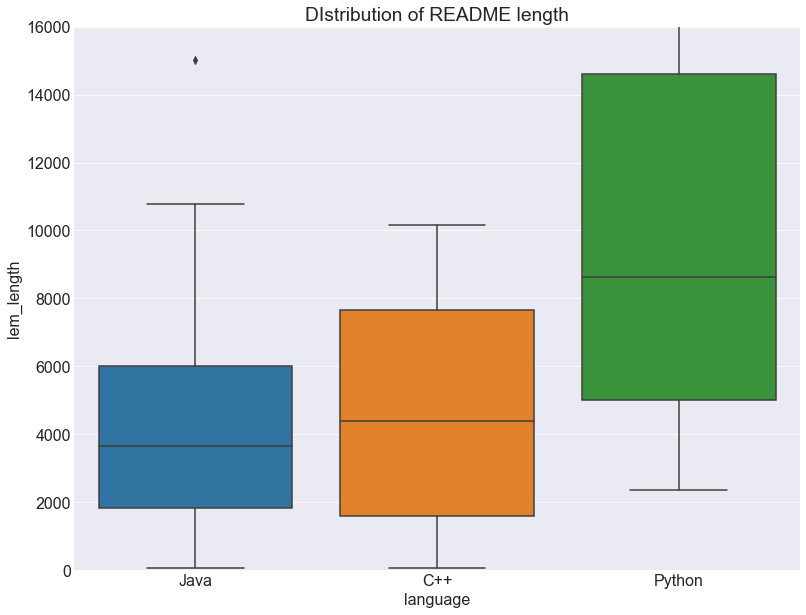

In [17]:
# A boxplot to represent the distributions of the README lengths
explore.box_plot(train, 'language', 'lem_length')
None

**Takeaways**

- The readme length varies by programming language
- Python has the longest average readme length
- C++ and Java have average readme length below 5,000
- There are some outliers with readme lengths over 300,000
- Median Readme Lengths for all languages except Python is around 4,000
- The length of the readme is statistically different from the overall mean for Java and C++. Python did not show a statistically significant difference likely due to the high standard deviation.

### Question: Do different programming languages use a different number of unique words?

Using the unique_counts() function from our explore module we can analyze what languages have unique words (or more accurately lemmatized tokens). This function will take our previously acquired word_counts dataframe and return separate dataframes which are an index of the unique word and their count for each language. These dataframes can then be used moving forward, if desired, or the length of them for comparison of how many uniques are from each language. 

In [18]:
# Using our unique_counts() function to get our unique dataframes. Takes our previously acquired word_counts df.
unique_p, unique_j, unique_c = explore.unique_counts(word_counts)

Comparison of how many uniques per language:

In [19]:
# Calling len() for each returned dataframe: unique_p (Python), unique_j (Java), unique_c (C++)
len(unique_p), len(unique_j), len(unique_c)

(12450, 2376, 2345)

**Takeaways**
- We have three dataframes of unique lemmatized tokens by language, where the token is the index and there is a count of how many times it is seen (in the train data). 
- Overall Python has the most unique tokens compared to Java and C++ for the READMEs we have, but this aligns with our previous exploration of README length generally

## Exploration Summary:
Through our exploration we did find some things worth considering when moving forward with modeling:

- There is a difference in the general length of the READMEs, and there is a statistical significance for two (Java and C++) of the languages compared to the overall mean. At a quick glance we can see that Python does have the largest word count on average, but this stems from having a number of READMEs that exceed the average word count generally. Python was still determined to not be statistically significant compared to the average word count. 

- The overall most common words tend to have to do with installation of libraries or packages for the coding languages, and is heavily skewed by Python in terms of frequency. 

- There are a lot of unique lemmatized 'words' for each language, with Python having the highest amount in this capacity by quite a margin. (12,000 + compared to ~2500 for Java or C++)

- Visually with WordClouds we can see that each language does have their own set of identifiers that will likely be used by the models, and this is confirmed (as seen in the various notebooks) through the exploration of Bigrams and Trigrams. 

Additionally there were some features that were engineered and will be utilized moving forward, these include word count and length metrics for original text, stemmed, and lemmatized versions (6 columns in total).

## Modeling

80 models were evaluated with the following options:
- Vectorizers: count vectorizer and tf-idf
- Models:
    - Multinomial Naive Bayes with default hyperparameters
    - Random Forest classifier with max depth of 1 and 2
    - Logistic Regression with C = {0.01, 0.1, 1.0}
    - Decision Tree classifier with max depth of 1 and 2

Top model based on highest accuracy on validate and least dropoff in performance from train to validate.

Models compared against a baseline of 33%. Because the data set is balanced among the three classes we have a 1/3 chance of choosing the correct language purely by chance.

In [20]:
target = 'language'
# Define list of vectorizers
vectorizers = [CountVectorizer, TfidfVectorizer]
# Define list of classification models
class_models = [MultinomialNB(), 
                RandomForestClassifier(random_state=123, max_depth = 1), 
                RandomForestClassifier(random_state=123, max_depth = 2), 
                LogisticRegression(C=0.01),
                LogisticRegression(C=0.1),
                LogisticRegression(C=1.0),
                DecisionTreeClassifier(max_depth=1),
               DecisionTreeClassifier(max_depth=2)]
# Establish range of ngrams to use - (1,2) means use both unigrams and bigrams
ngram_range_values = [(1,1),(1,2),(2,2),(1,3),(2,3)]
print_results_param = False

In [21]:
results = model.model_multiple(vectorizers, class_models, ngram_range_values, train, validate, target, print_results_param)

Model results sorted by highest accuracy on validate, and lowest dropoff in accuracy from train to validate.

In [22]:
results.head(3)

,model_parameters,train_accuracy,validate_accuracy,dropoff,feature_names,feature_importances,top_features
"(TfidfVectorizer, RandomForestClassifier, (1, 1))","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.904762,0.666667,0.238095,"[00, 000000true, 0001, 0003, 001, 0016666, 004...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[graph, java, experiment, text, built, matplot..."
"(TfidfVectorizer, RandomForestClassifier, (1, 1))","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.952381,0.666667,0.285714,"[00, 000000true, 0001, 0003, 001, 0016666, 004...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[license, clustering, text, built, java, matpl..."
"(CountVectorizer, DecisionTreeClassifier, (1, 1))","{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.690476,0.638889,0.051587,"[00, 000000true, 0001, 0003, 001, 0016666, 004...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[github580, githubhttpsaifacebookcomblogusingn..."


Highest validate accuracy is the Random Forest Classifier but it appears quite overfit with a 24% dropoff in accuracy from train to validate. The Decision Tree Classifer appears to be best using the count vectorizer with unigrams solely and a max depth of 2. This model will be tested on the witheld test set.

In [23]:
train_class_report, validate_class_report, feature_names, feature_importances= model.model_words(CountVectorizer, 
                  DecisionTreeClassifier(max_depth = 2),
                  ngrams_range_value=(1,1), 
                  train=train, 
                  validate = test, # note use of test 
                  target='language',
                  print_results=False)

In [24]:
pd.DataFrame(validate_class_report)

,C++,Java,Python,accuracy,macro avg,weighted avg
precision,0.533333,0.750000,0.571429,0.6,0.618254,0.618254
recall,0.800000,0.600000,0.400000,0.6,0.600000,0.600000
f1-score,0.640000,0.666667,0.470588,0.6,0.592418,0.592418
support,10.000000,10.000000,10.000000,0.6,30.000000,30.000000


Slight drop in accuracy but overall pretty good at 60%, beating the baseline by 27%!

Plotting top model performance

In [25]:
# Grab just the models that did not overfit
non_overfit_results = results[results.dropoff<0.1]
# Create a list of nans for making the test accuracy column
test_accuracy = [np.nan for i in range(len(non_overfit_results))]
# Value from testing on witheld test set, above
test_accuracy[0] = 0.6
non_overfit_results["test_accuracy"] = test_accuracy
# Create cleaner labels for y ticks
yticklabels = [' '.join(t.replace(',',"").split())[2:-1].replace("' '","\n").replace("' (","\n(") for t in non_overfit_results.index.astype('string')]

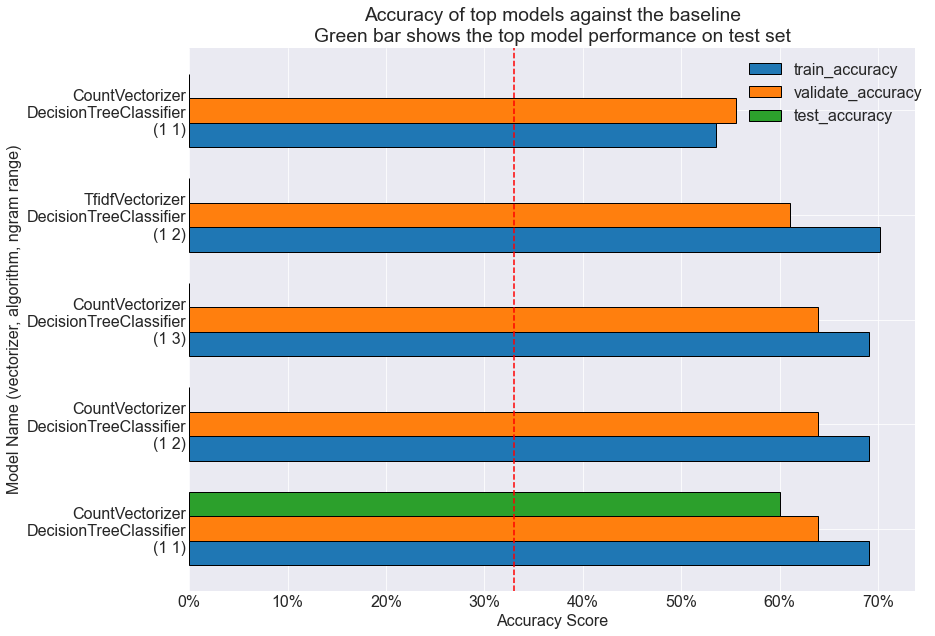

In [26]:
# Create bar chart showing performance of top models
non_overfit_results = non_overfit_results[['train_accuracy','validate_accuracy','test_accuracy']].sort_values(by=['validate_accuracy'], ascending = [False]).head()
explore.top_model_perform(non_overfit_results, yticklabels)

#### Modeling takeaways

Overall only 22 of 80 models exhibited a dropoff in train to validate accuracy of less than 10%, indicating most models overfit to the train data. The only algorithm with decent performance without overfitting was the Decision Tree Classifier. Multinomial Naive Bayes didn't overfit but accuracy was around 33%. Performance with the Decision Tree Classifier was best with the Count Vectorizer and was identical whether solely unigrams were used vs with bigrams and/or trigrams. 

# Conclusion

- The programming language of a machine learning C++, Java, or Python repository on Github can be predicted using natural language processing techniques and classification models with accuracies of around 60%. This does perform better than the baseline (33%) under the assumption of a random assignment from the three languages we included. 
- Some of the READMEs are not written in english, so the lemmatized ‘words’ that remain do not necessarily represent the README properly.
- Acquiring READMEs by star ranking produced a lot of results for robust software that likely does not represent that average README by language and greatly increased the number of ‘unique’ words/tokens that are associated with the software itself and not the language it is written for.

### Moving Forward:
- Including more languages, a larger number of READMEs and different categories of topics we could test our bag of words, unique words, and outcomes to see if the NLP model works on the niche set of parameters we utilized or has broader implications for the coding languages themselves. 
- Varying the ‘star’ ranking and comparing the predicted outcomes by language could give indication to what degree of unique language makes for a better overall README quality, and if there is a threshold where it becomes too cumbersome.  